In [1]:
import os
from tqdm import tqdm
import pickle
import random

import pandas as pd
import numpy as np
import scipy
from sklearn.metrics.pairwise import pairwise_kernels
import matplotlib.pyplot as plt

from metaspace import SMInstance
from anndata import AnnData
from metaspace2anndata import dataset_to_anndata
import scanpy as sc
import seaborn as sns
from molmass import Formula

import utils
from config import store_dir, data_dir, date_key
%load_ext autoreload
%autoreload 2

# Load data

In [2]:
dss = pickle.load(open(os.path.join(store_dir, 'all_datasets.pickle'), "rb" ) )
results = pickle.load(open(os.path.join(store_dir, 'hmdb4_results.pickle'), "rb" ) )
hmdb_v4 = pd.read_csv(os.path.join(data_dir, 'databases/HMDB_v4.csv'), index_col=None).set_index('chemical_formula')
md = utils.make_metadata_dict(dss, results, only_results=True)
mdt = utils.clean_metadata_table(utils.metadata_dict_totable(md))

In [3]:
md = utils.make_metadata_dict(dss, results, only_results=True)
mdt = utils.clean_metadata_table(utils.metadata_dict_totable(md))

In [4]:
mdt['top_Organism'] = utils.top_feature_col(mdt['Organism'], top=10)
mdt['top_Condition'] = utils.top_feature_col(mdt['Condition'], top=10)
mdt['top_Organism_Part'] = utils.top_feature_col(mdt['Organism_Part'], top=15)
mdt['top_Polarity'] = utils.top_feature_col(mdt['Polarity'], top=10)
mdt['top_maldi_matrix'] = utils.top_feature_col(mdt['maldi_matrix'], top=8)
mdt['top_Group'] = utils.top_feature_col(mdt['Group'], top=10)

In [258]:
# adata = utils.make_ion_anndata(results, mdt, fdr_cutoff=0.5, only_onSample=True)

adata = utils.make_molecule_anndata(results, mdt, fdr_cutoff=0.2, only_onSample=True)
adata.var = adata.var.rename(columns={0: 'molecule'}).reset_index().set_index('molecule').drop(columns='index')

100%|██████████| 7443/7443 [00:10<00:00, 715.39it/s]


10865  features


100%|██████████| 7443/7443 [00:31<00:00, 235.94it/s]
/home/trose/projects/metaspace_evaluation/utils.py:186: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  return AnnData(X=mol_data.to_numpy(), var=pd.DataFrame(mol_features), obs=mdt.loc[mol_data.index, :])
/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [259]:
sc.pp.filter_genes(adata, min_cells=100) # 200
sc.pp.filter_cells(adata, min_genes=20) # 50
sc.pp.normalize_total(adata, target_sum=1e4)
#sc.tl.pca(adata)
#sc.external.pp.bbknn(adata, batch_key='maldi_matrix', metric='euclidean', neighbors_within_batch=1)
sc.pp.neighbors(adata, metric='cosine')
sc.tl.umap(adata)

         Falling back to preprocessing with `sc.pp.pca` and default params.


In [260]:
adata

AnnData object with n_obs × n_vars = 4437 × 1631
    obs: 'Organism', 'Condition', 'Organism_Part', 'Polarity', 'maldi_matrix', 'Group', 'mzmin', 'mzmax', 'Analyzer', 'Ionisation_Source', 'top_Organism', 'top_Condition', 'top_Organism_Part', 'top_Polarity', 'top_maldi_matrix', 'top_Group', 'n_genes'
    var: 'n_cells'
    uns: 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap'
    obsp: 'distances', 'connectivities'

<AxesSubplot: xlabel='top_maldi_matrix', ylabel='count'>

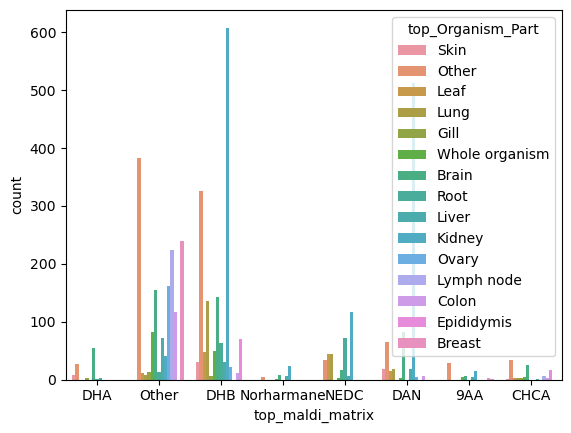

In [261]:
sns.countplot(data=adata.obs, x='top_maldi_matrix', hue='top_Organism_Part')

# Positive

In [262]:
adata_pos = adata[adata.obs['Polarity']=='Positive',:]

sc.pp.filter_genes(adata_pos, min_cells=100) # 200
sc.pp.filter_cells(adata_pos, min_genes=20) # 50
#sc.pp.normalize_total(adata_pos, target_sum=1e4)

#sc.pp.neighbors(adata_pos, metric='cosine')
#sc.tl.leiden(adata_pos)
#sc.tl.umap(adata_pos)

adata_pos.var['mass'] = [Formula(x).mass for x in adata_pos.var.index.values]

/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number


In [263]:
np.isnan(adata_pos.X).any()

False

<AxesSubplot: xlabel='top_maldi_matrix', ylabel='count'>

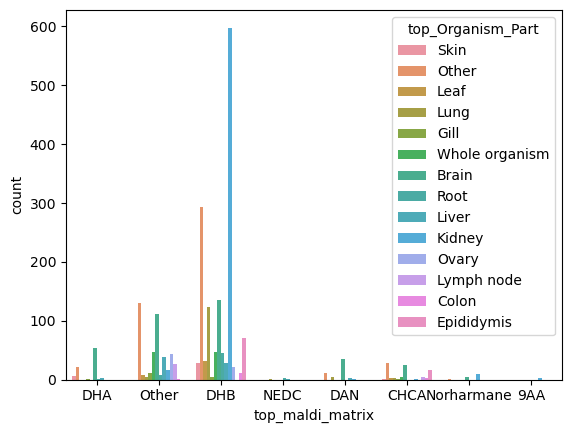

In [264]:
sns.countplot(data=adata_pos.obs, x='top_maldi_matrix', hue='top_Organism_Part')

## DHB

In [265]:
adata_pos_dhb = adata_pos[adata_pos.obs['top_maldi_matrix']=='DHB',:]

sc.pp.neighbors(adata_pos_dhb, metric='cosine')
sc.tl.leiden(adata_pos_dhb)
sc.tl.umap(adata_pos_dhb)

In [266]:
# Updated min mass

min_mass_dict = {}
max_mass_dict = {}

for i in range(adata_pos_dhb.X.shape[0]):
    ds_id = adata_pos_dhb.obs.index[i]
    dataslice = adata_pos_dhb.X[i, :] > 0
    
    min_mass_dict[ds_id] = adata_pos_dhb.var['mass'][dataslice].min()
    max_mass_dict[ds_id] = adata_pos_dhb.var['mass'][dataslice].max()
    
adata_pos_dhb.obs['minmass'] = pd.Series(min_mass_dict)
adata_pos_dhb.obs['maxmass'] = pd.Series(max_mass_dict)

/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


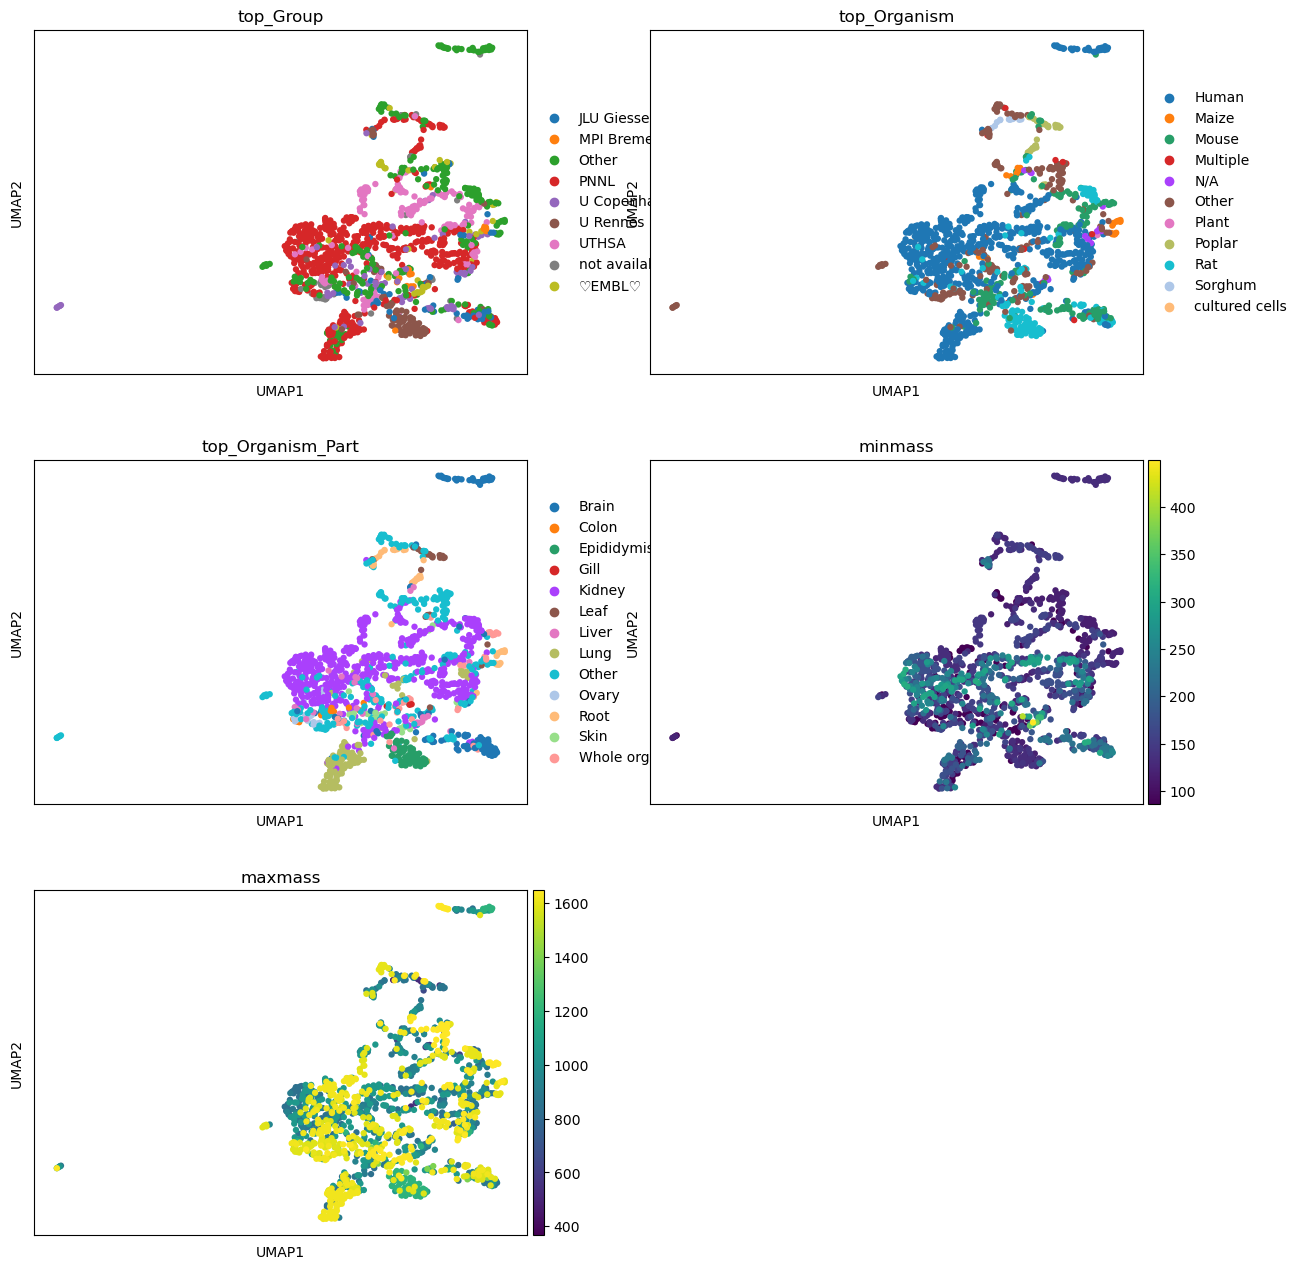

In [267]:
sc.pl.umap(adata_pos_dhb, color=['top_Group', 'top_Organism', 'top_Organism_Part', 'minmass', 'maxmass'], 
           ncols=2)

In [268]:
adata_pos.var['mass'][dataslice].min()

130.25115399999999

<AxesSubplot: xlabel='minmass', ylabel='Count'>

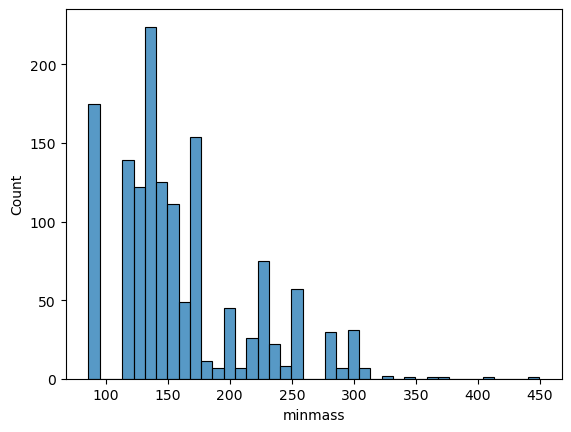

In [269]:
sns.histplot(data=adata_pos_dhb.obs, x='minmass')

<AxesSubplot: xlabel='maxmass', ylabel='Count'>

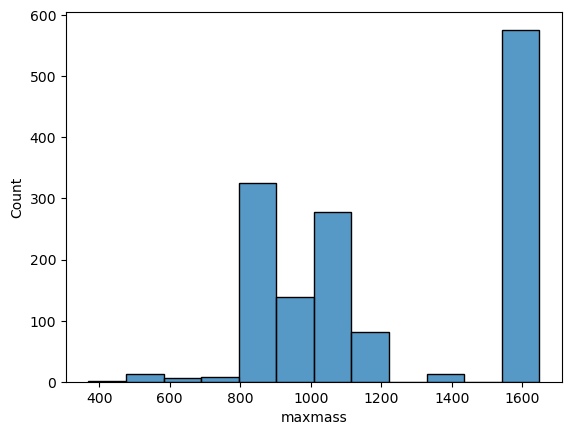

In [270]:
sns.histplot(data=adata_pos_dhb.obs, x='maxmass')

In [271]:
np.isnan(adata_pos_dhb.X).any()

False

## MZ range

In [272]:
(adata_pos_dhb.var['mass'] > 100) & (adata_pos_dhb.var['mass'] > 100)

molecule
C9H18O         True
C48H86NO8P     True
C23H45NO5      True
C59H90O4       True
C40H80O13P2    True
               ... 
C18H37NO2      True
C10H21NO4      True
C41H80NO8P     True
C43H82NO8P     True
C13H8O4        True
Name: mass, Length: 714, dtype: bool

In [273]:
adata_pos_dhb_mz = adata_pos_dhb[:,adata_pos_dhb.var['mass'] < 1400]
adata_pos_dhb_mz = adata_pos_dhb_mz[:,adata_pos_dhb_mz.var['mass'] > 100]

sc.pp.pca(adata_pos_dhb_mz)
sc.pp.neighbors(adata_pos_dhb_mz, metric='cosine')
sc.tl.leiden(adata_pos_dhb_mz)
sc.tl.umap(adata_pos_dhb_mz)

In [274]:
adata_pos_dhb_mz

AnnData object with n_obs × n_vars = 1439 × 706
    obs: 'Organism', 'Condition', 'Organism_Part', 'Polarity', 'maldi_matrix', 'Group', 'mzmin', 'mzmax', 'Analyzer', 'Ionisation_Source', 'top_Organism', 'top_Condition', 'top_Organism_Part', 'top_Polarity', 'top_maldi_matrix', 'top_Group', 'n_genes', 'leiden', 'minmass', 'maxmass'
    var: 'n_cells', 'mass'
    uns: 'neighbors', 'umap', 'leiden', 'top_Group_colors', 'top_Organism_colors', 'top_Organism_Part_colors', 'pca'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [275]:
np.isnan(adata_pos_dhb_mz.X).any()

False

/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


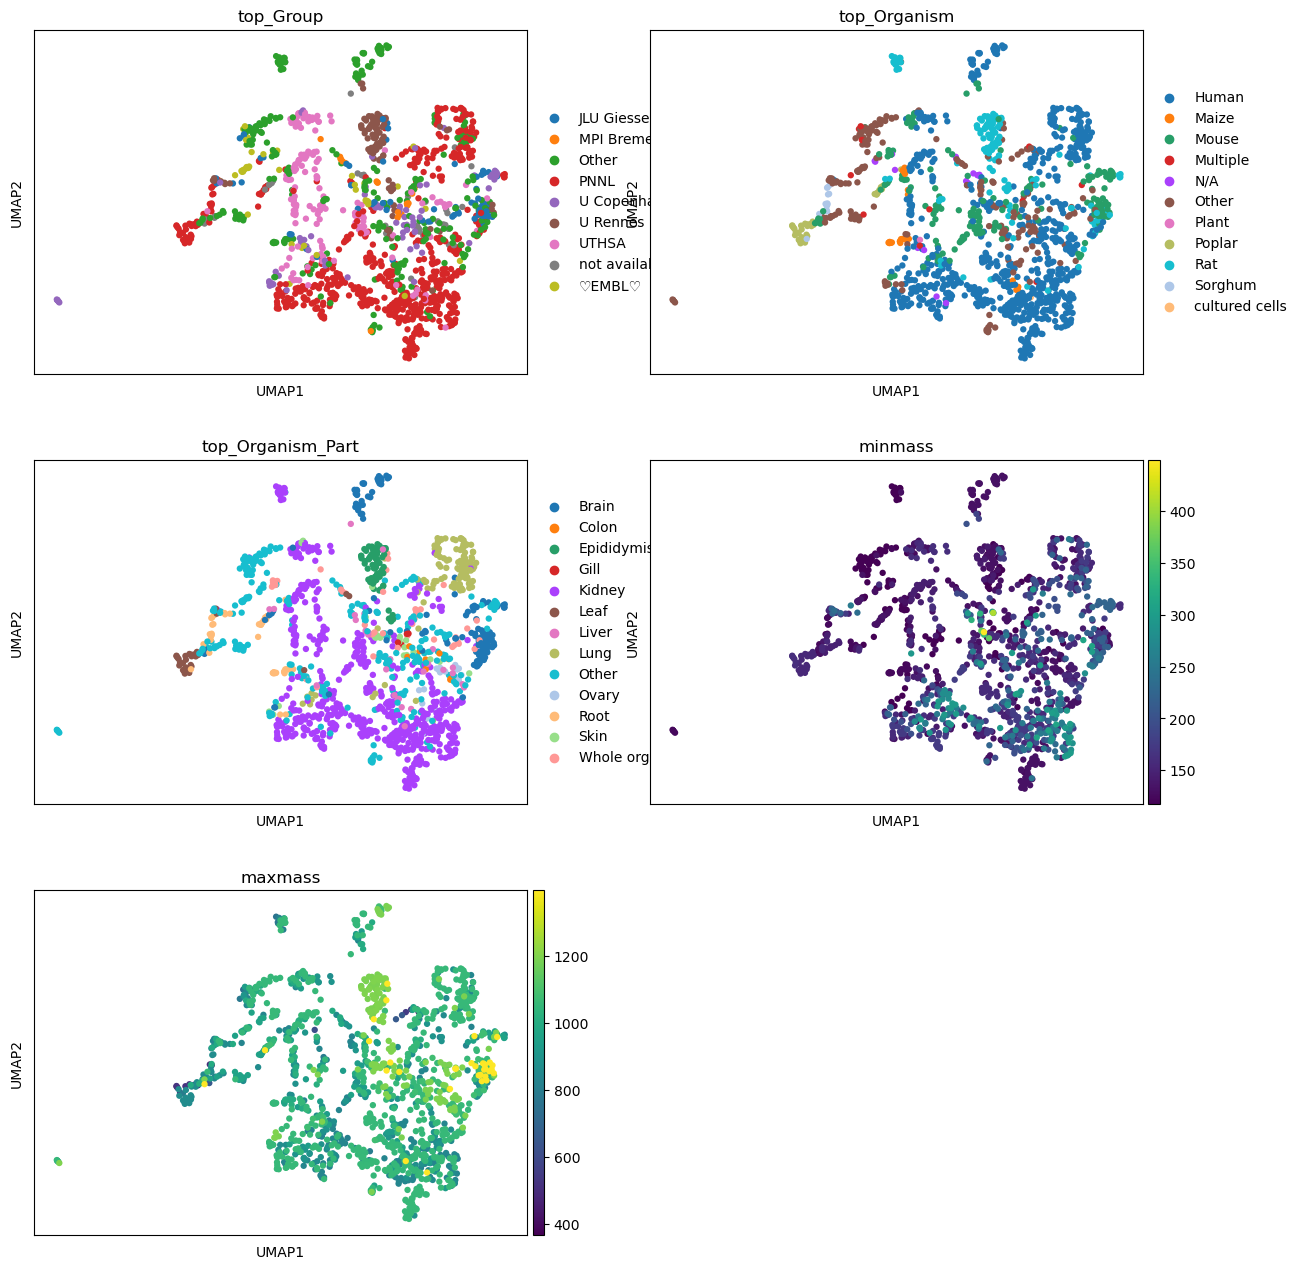

In [276]:
adat = adata_pos_dhb_mz
min_mass_dict = {}
max_mass_dict = {}

for i in range(adat.X.shape[0]):
    ds_id = adat.obs.index[i]
    dataslice = adat.X[i, :] > 0
    
    min_mass_dict[ds_id] = adat.var['mass'][dataslice].min()
    max_mass_dict[ds_id] = adat.var['mass'][dataslice].max()
    
adat.obs['minmass'] = pd.Series(min_mass_dict)
adat.obs['maxmass'] = pd.Series(max_mass_dict)

sc.pl.umap(adat, color=['top_Group', 'top_Organism', 'top_Organism_Part', 'minmass', 'maxmass'], 
           ncols=2)

## Select tissues

In [277]:
# Tissues
tissue_list = ['Brain', 'Colon', 'Epididymis', 'Kidney', 'Liver', 'Lung', 'Ovary', 'Skin']


adata_pos_dhb_mz_tissue = adata_pos_dhb_mz[adata_pos_dhb_mz.obs['top_Organism_Part'].isin(tissue_list), :]

sc.pp.pca(adata_pos_dhb_mz_tissue)
sc.pp.neighbors(adata_pos_dhb_mz_tissue, metric='cosine')
sc.tl.leiden(adata_pos_dhb_mz_tissue)
sc.tl.umap(adata_pos_dhb_mz_tissue)

In [278]:
adata_pos_dhb_mz_tissue

AnnData object with n_obs × n_vars = 1017 × 706
    obs: 'Organism', 'Condition', 'Organism_Part', 'Polarity', 'maldi_matrix', 'Group', 'mzmin', 'mzmax', 'Analyzer', 'Ionisation_Source', 'top_Organism', 'top_Condition', 'top_Organism_Part', 'top_Polarity', 'top_maldi_matrix', 'top_Group', 'n_genes', 'leiden', 'minmass', 'maxmass'
    var: 'n_cells', 'mass'
    uns: 'neighbors', 'umap', 'leiden', 'top_Group_colors', 'top_Organism_colors', 'top_Organism_Part_colors', 'pca'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [279]:
np.isnan(adata_pos_dhb_mz.X).any()

False

In [280]:
pd.get_dummies(adata_pos_dhb_mz_tissue.obs['top_Organism_Part']).to_numpy()

array([[0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


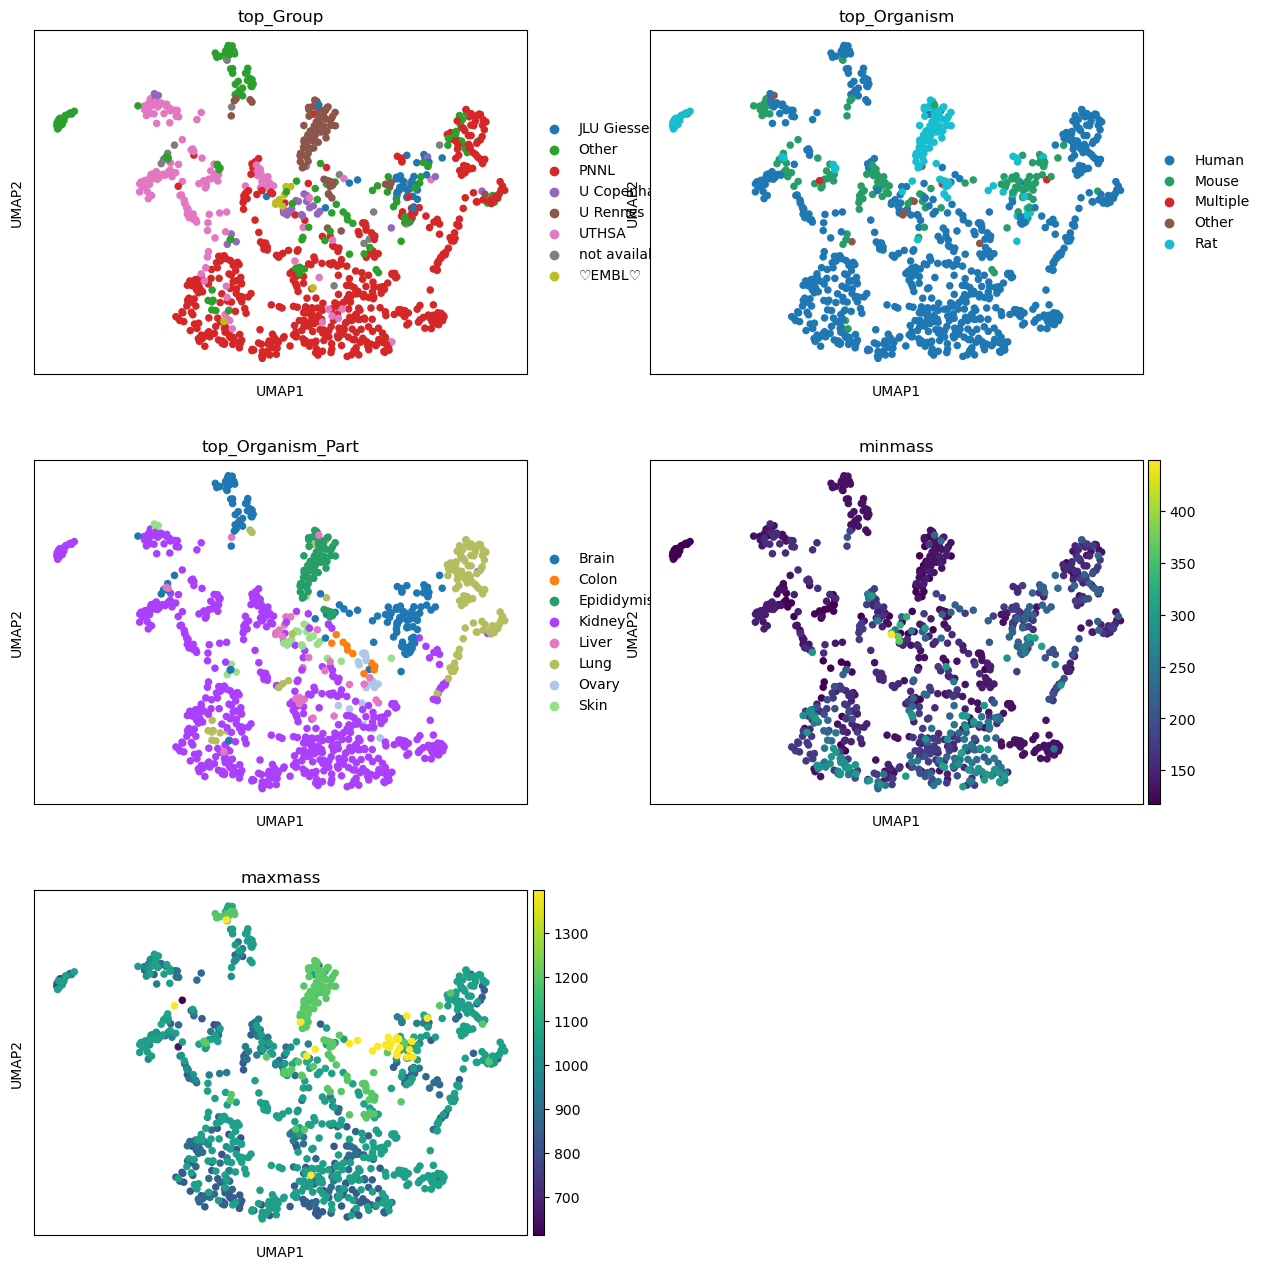

In [281]:
adat = adata_pos_dhb_mz_tissue
min_mass_dict = {}
max_mass_dict = {}

for i in range(adat.X.shape[0]):
    ds_id = adat.obs.index[i]
    dataslice = adat.X[i, :] > 0
    
    min_mass_dict[ds_id] = adat.var['mass'][dataslice].min()
    max_mass_dict[ds_id] = adat.var['mass'][dataslice].max()
    
adat.obs['minmass'] = pd.Series(min_mass_dict)
adat.obs['maxmass'] = pd.Series(max_mass_dict)

sc.pl.umap(adat, color=['top_Group', 'top_Organism', 'top_Organism_Part', 'minmass', 'maxmass'], 
           ncols=2)

## Ignored: Correcting lab effect

Does not make sense with combat, maybe try other tools later

In [282]:
# adata_pos_dhb_mz_tissue_cor = adata_pos_dhb_mz_tissue.copy()

In [283]:
#tmp = sc.pp.combat(adata_pos_dhb_mz_tissue_cor, 
#             key='top_Group', 
#             inplace=False,
#             covariates=['top_Organism_Part']
#            )

#adata_pos_dhb_mz_tissue_cor.X = tmp

In [284]:
#sc.pp.pca(adata_pos_dhb_mz_tissue_cor)
#sc.pp.neighbors(adata_pos_dhb_mz_tissue_cor, metric='cosine')
#sc.tl.leiden(adata_pos_dhb_mz_tissue_cor)
#sc.tl.umap(adata_pos_dhb_mz_tissue_cor)


In [285]:
#adat = adata_pos_dhb_mz_tissue_cor
#min_mass_dict = {}
#max_mass_dict = {}

#for i in range(adat.X.shape[0]):
#    ds_id = adat.obs.index[i]
#    dataslice = adat.X[i, :] > 0
    
#    min_mass_dict[ds_id] = adat.var['mass'][dataslice].min()
#    max_mass_dict[ds_id] = adat.var['mass'][dataslice].max()
    
#adat.obs['minmass'] = pd.Series(min_mass_dict)
#adat.obs['maxmass'] = pd.Series(max_mass_dict)

#sc.pl.umap(adat, color=['top_Group', 'top_Organism', 'top_Organism_Part', 'minmass', 'maxmass'], 
#           ncols=2)

## Tissue prototyping

In [286]:
tissue_mol_freq = {}
tissue_top_datasets = {}

mol_freq_cutoff = 0.1
top_ds_cutoff = 0.2

### Brain

/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


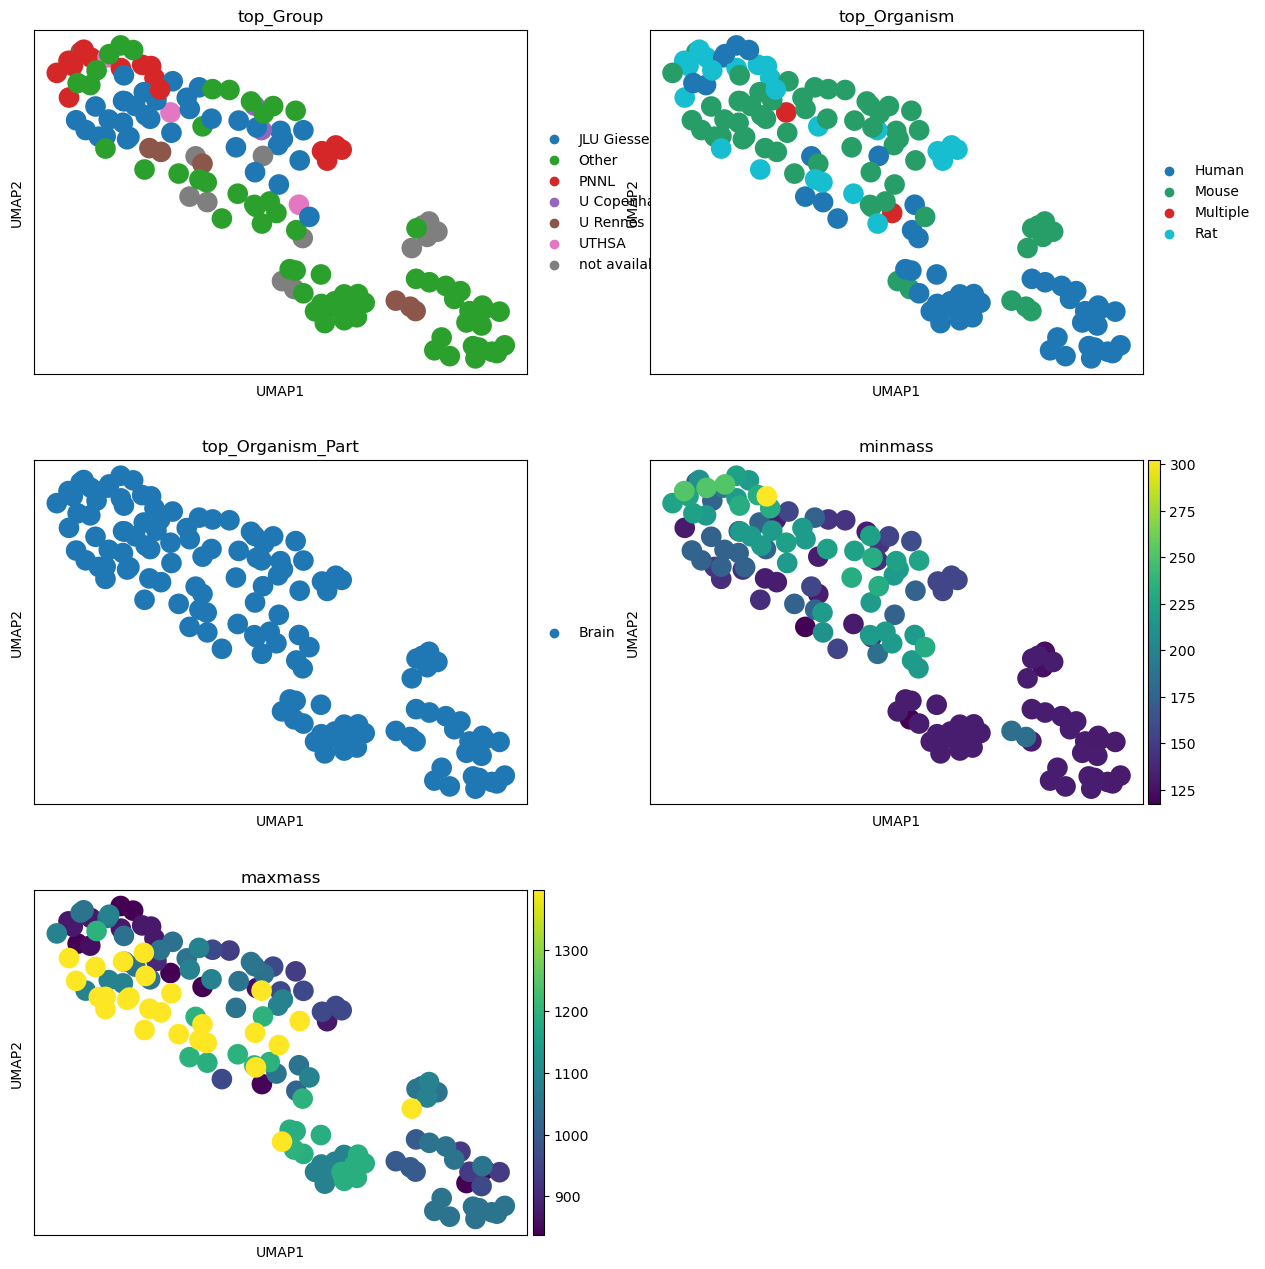

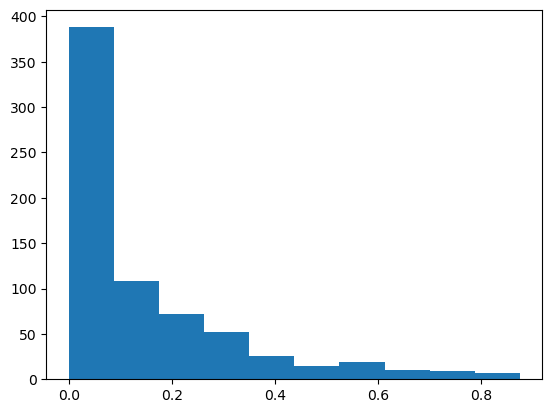

In [287]:
tissue = 'Brain'
adat = adata_pos_dhb_mz_tissue[adata_pos_dhb_mz_tissue.obs['top_Organism_Part']==tissue, :]

sc.pp.pca(adat)
sc.pp.neighbors(adat, metric='cosine')
sc.tl.leiden(adat)
sc.tl.umap(adat)

min_mass_dict = {}
max_mass_dict = {}

for i in range(adat.X.shape[0]):
    ds_id = adat.obs.index[i]
    dataslice = adat.X[i, :] > 0
    
    min_mass_dict[ds_id] = adat.var['mass'][dataslice].min()
    max_mass_dict[ds_id] = adat.var['mass'][dataslice].max()
    
adat.obs['minmass'] = pd.Series(min_mass_dict)
adat.obs['maxmass'] = pd.Series(max_mass_dict)

sc.pl.umap(adat, color=['top_Group', 'top_Organism', 'top_Organism_Part', 'minmass', 'maxmass'], 
           ncols=2)


mol_freq = pd.Series((adat.X > 0).sum(axis=0), index=adat.var.index) / adat.X.shape[0]

plt.hist(mol_freq)

com = mol_freq.sort_values(ascending=False)[int(len(mol_freq)*mol_freq_cutoff)]

top_datasets = pd.Series((adat.X[:, mol_freq >= com] > 0).sum(axis=1), index=adat.obs.index)

co = top_datasets.sort_values(ascending=False)[int(len(top_datasets)*top_ds_cutoff)]

mol_freq2 = pd.Series((adat.X[top_datasets>=co, :] > 0).sum(axis=0), index=adat.var.index) / adat.X[top_datasets>=co, :].shape[0]

tissue_mol_freq[tissue] = mol_freq2
tissue_top_datasets[tissue] = top_datasets

### Colon


/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


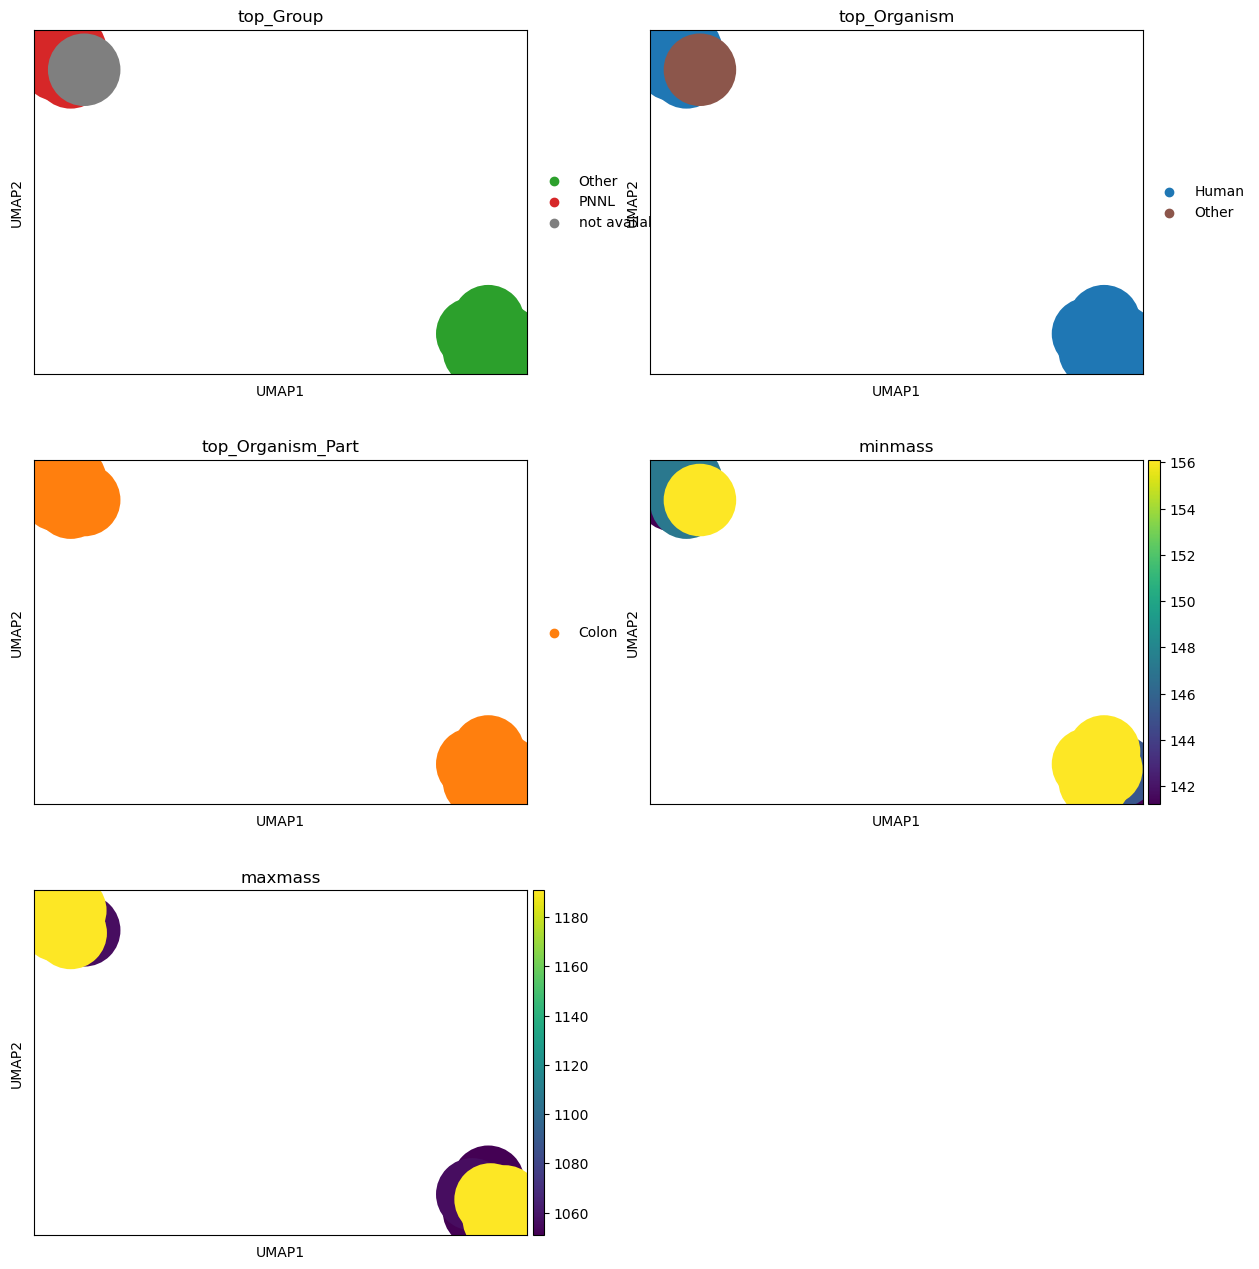

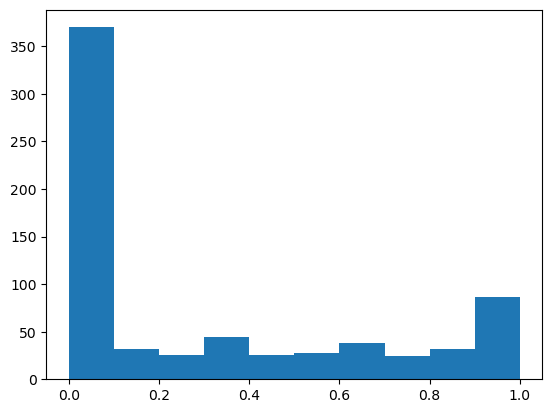

In [288]:
tissue = 'Colon'
adat = adata_pos_dhb_mz_tissue[adata_pos_dhb_mz_tissue.obs['top_Organism_Part']==tissue, :]

sc.pp.pca(adat)
sc.pp.neighbors(adat, metric='cosine')
sc.tl.leiden(adat)
sc.tl.umap(adat)

min_mass_dict = {}
max_mass_dict = {}

for i in range(adat.X.shape[0]):
    ds_id = adat.obs.index[i]
    dataslice = adat.X[i, :] > 0
    
    min_mass_dict[ds_id] = adat.var['mass'][dataslice].min()
    max_mass_dict[ds_id] = adat.var['mass'][dataslice].max()
    
adat.obs['minmass'] = pd.Series(min_mass_dict)
adat.obs['maxmass'] = pd.Series(max_mass_dict)

sc.pl.umap(adat, color=['top_Group', 'top_Organism', 'top_Organism_Part', 'minmass', 'maxmass'], 
           ncols=2)


mol_freq = pd.Series((adat.X > 0).sum(axis=0), index=adat.var.index) / adat.X.shape[0]

plt.hist(mol_freq)

com = mol_freq.sort_values(ascending=False)[int(len(mol_freq)*mol_freq_cutoff)]

top_datasets = pd.Series((adat.X[:, mol_freq >= com] > 0).sum(axis=1), index=adat.obs.index)

co = top_datasets.sort_values(ascending=False)[int(len(top_datasets)*top_ds_cutoff)]

mol_freq2 = pd.Series((adat.X[top_datasets>=co, :] > 0).sum(axis=0), index=adat.var.index) / adat.X[top_datasets>=co, :].shape[0]

tissue_mol_freq[tissue] = mol_freq2
tissue_top_datasets[tissue] = top_datasets

### Epididymis

/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


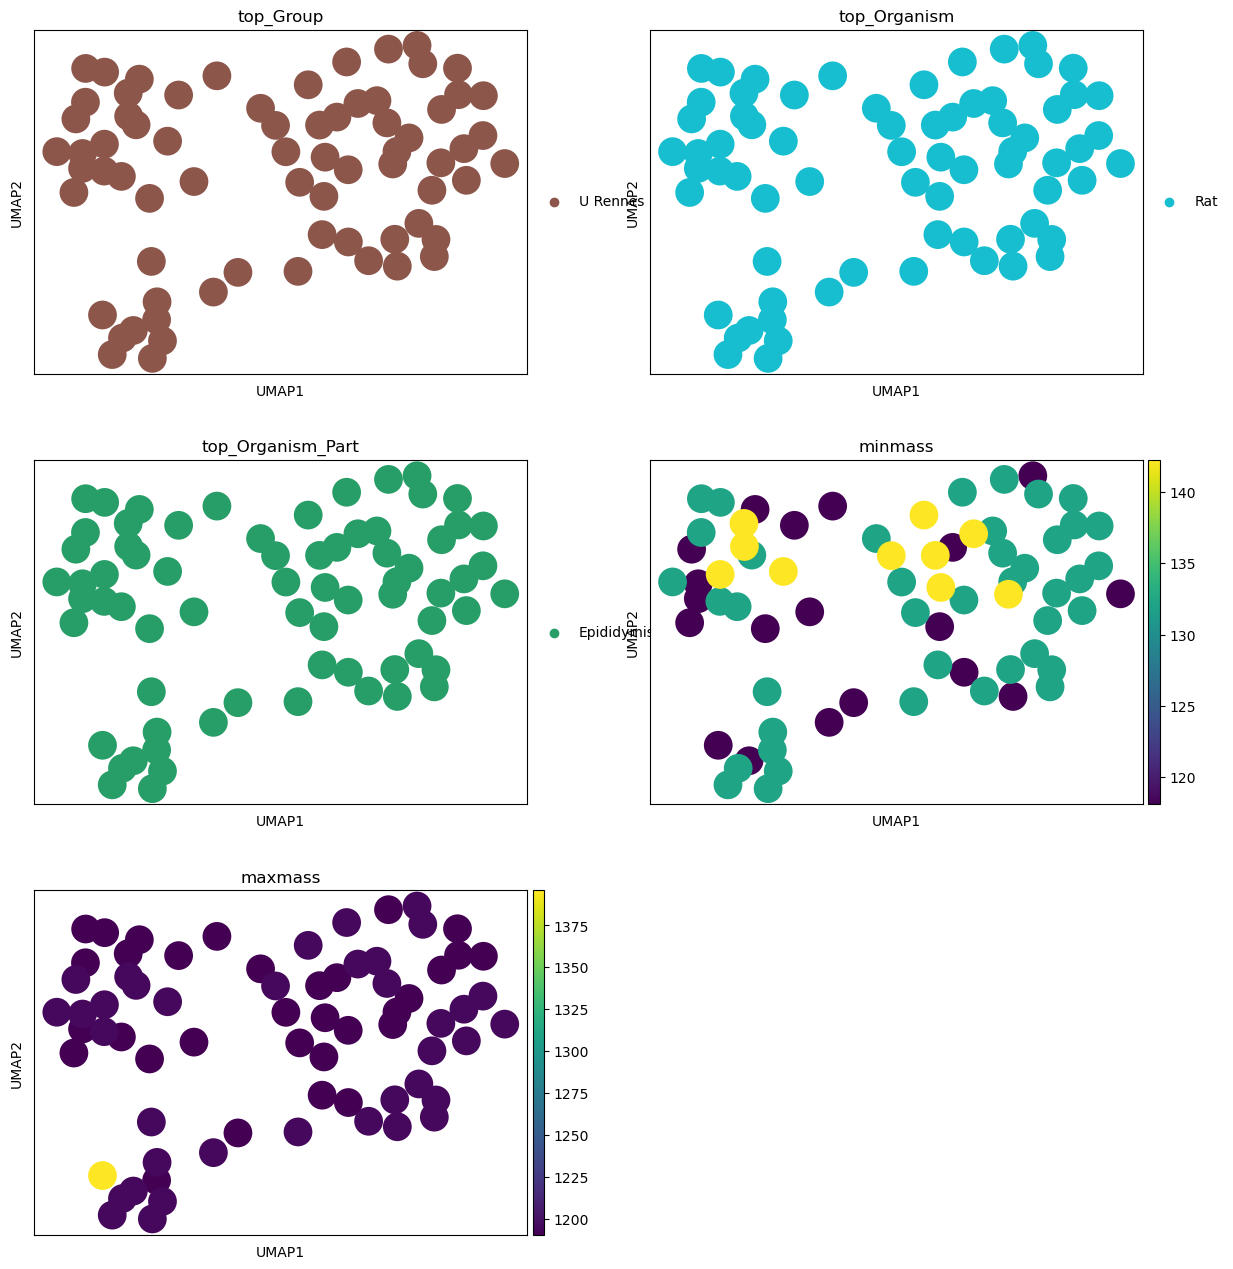

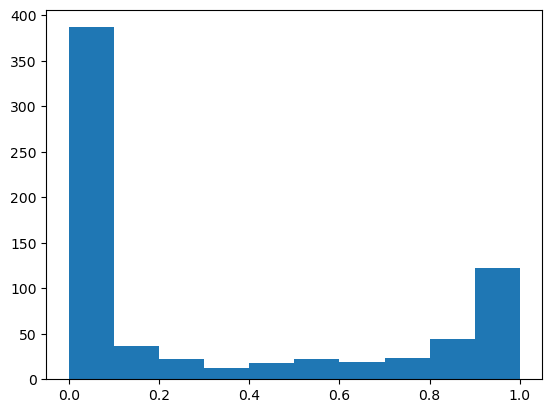

In [289]:
tissue = 'Epididymis'
adat = adata_pos_dhb_mz_tissue[adata_pos_dhb_mz_tissue.obs['top_Organism_Part']==tissue, :]

sc.pp.pca(adat)
sc.pp.neighbors(adat, metric='cosine')
sc.tl.leiden(adat)
sc.tl.umap(adat)

min_mass_dict = {}
max_mass_dict = {}

for i in range(adat.X.shape[0]):
    ds_id = adat.obs.index[i]
    dataslice = adat.X[i, :] > 0
    
    min_mass_dict[ds_id] = adat.var['mass'][dataslice].min()
    max_mass_dict[ds_id] = adat.var['mass'][dataslice].max()
    
adat.obs['minmass'] = pd.Series(min_mass_dict)
adat.obs['maxmass'] = pd.Series(max_mass_dict)

sc.pl.umap(adat, color=['top_Group', 'top_Organism', 'top_Organism_Part', 'minmass', 'maxmass'], 
           ncols=2)


mol_freq = pd.Series((adat.X > 0).sum(axis=0), index=adat.var.index) / adat.X.shape[0]

plt.hist(mol_freq)

com = mol_freq.sort_values(ascending=False)[int(len(mol_freq)*mol_freq_cutoff)]

top_datasets = pd.Series((adat.X[:, mol_freq >= com] > 0).sum(axis=1), index=adat.obs.index)

co = top_datasets.sort_values(ascending=False)[int(len(top_datasets)*top_ds_cutoff)]

mol_freq2 = pd.Series((adat.X[top_datasets>=co, :] > 0).sum(axis=0), index=adat.var.index) / adat.X[top_datasets>=co, :].shape[0]

tissue_mol_freq[tissue] = mol_freq2
tissue_top_datasets[tissue] = top_datasets

### Kidney

/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


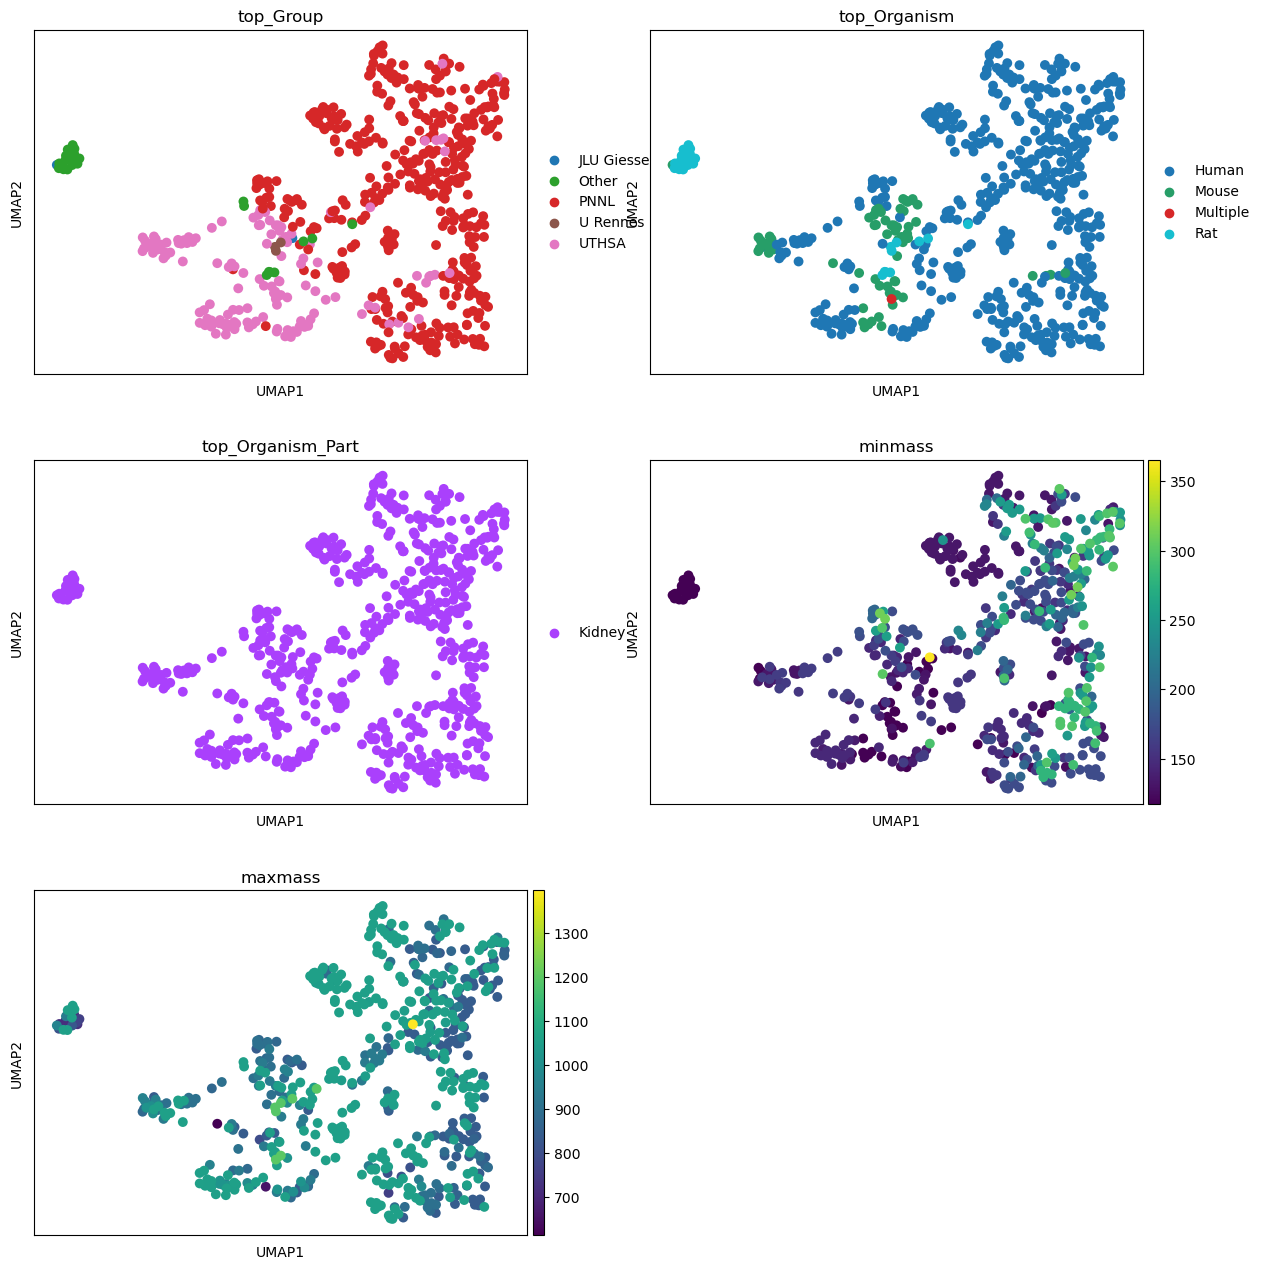

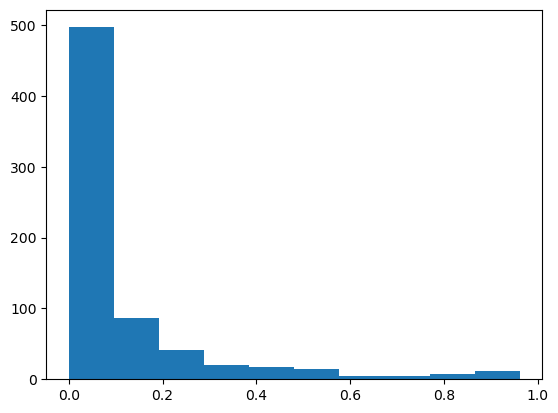

In [290]:
tissue = 'Kidney'
adat = adata_pos_dhb_mz_tissue[adata_pos_dhb_mz_tissue.obs['top_Organism_Part']==tissue, :]

sc.pp.pca(adat)
sc.pp.neighbors(adat, metric='cosine')
sc.tl.leiden(adat)
sc.tl.umap(adat)

min_mass_dict = {}
max_mass_dict = {}

for i in range(adat.X.shape[0]):
    ds_id = adat.obs.index[i]
    dataslice = adat.X[i, :] > 0
    
    min_mass_dict[ds_id] = adat.var['mass'][dataslice].min()
    max_mass_dict[ds_id] = adat.var['mass'][dataslice].max()
    
adat.obs['minmass'] = pd.Series(min_mass_dict)
adat.obs['maxmass'] = pd.Series(max_mass_dict)

sc.pl.umap(adat, color=['top_Group', 'top_Organism', 'top_Organism_Part', 'minmass', 'maxmass'], 
           ncols=2)


mol_freq = pd.Series((adat.X > 0).sum(axis=0), index=adat.var.index) / adat.X.shape[0]

plt.hist(mol_freq)

com = mol_freq.sort_values(ascending=False)[int(len(mol_freq)*mol_freq_cutoff)]

top_datasets = pd.Series((adat.X[:, mol_freq >= com] > 0).sum(axis=1), index=adat.obs.index)

co = top_datasets.sort_values(ascending=False)[int(len(top_datasets)*top_ds_cutoff)]

mol_freq2 = pd.Series((adat.X[top_datasets>=co, :] > 0).sum(axis=0), index=adat.var.index) / adat.X[top_datasets>=co, :].shape[0]

tissue_mol_freq[tissue] = mol_freq2
tissue_top_datasets[tissue] = top_datasets

### Liver

In [291]:
mol_freq.max()

0.9615384615384616

/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


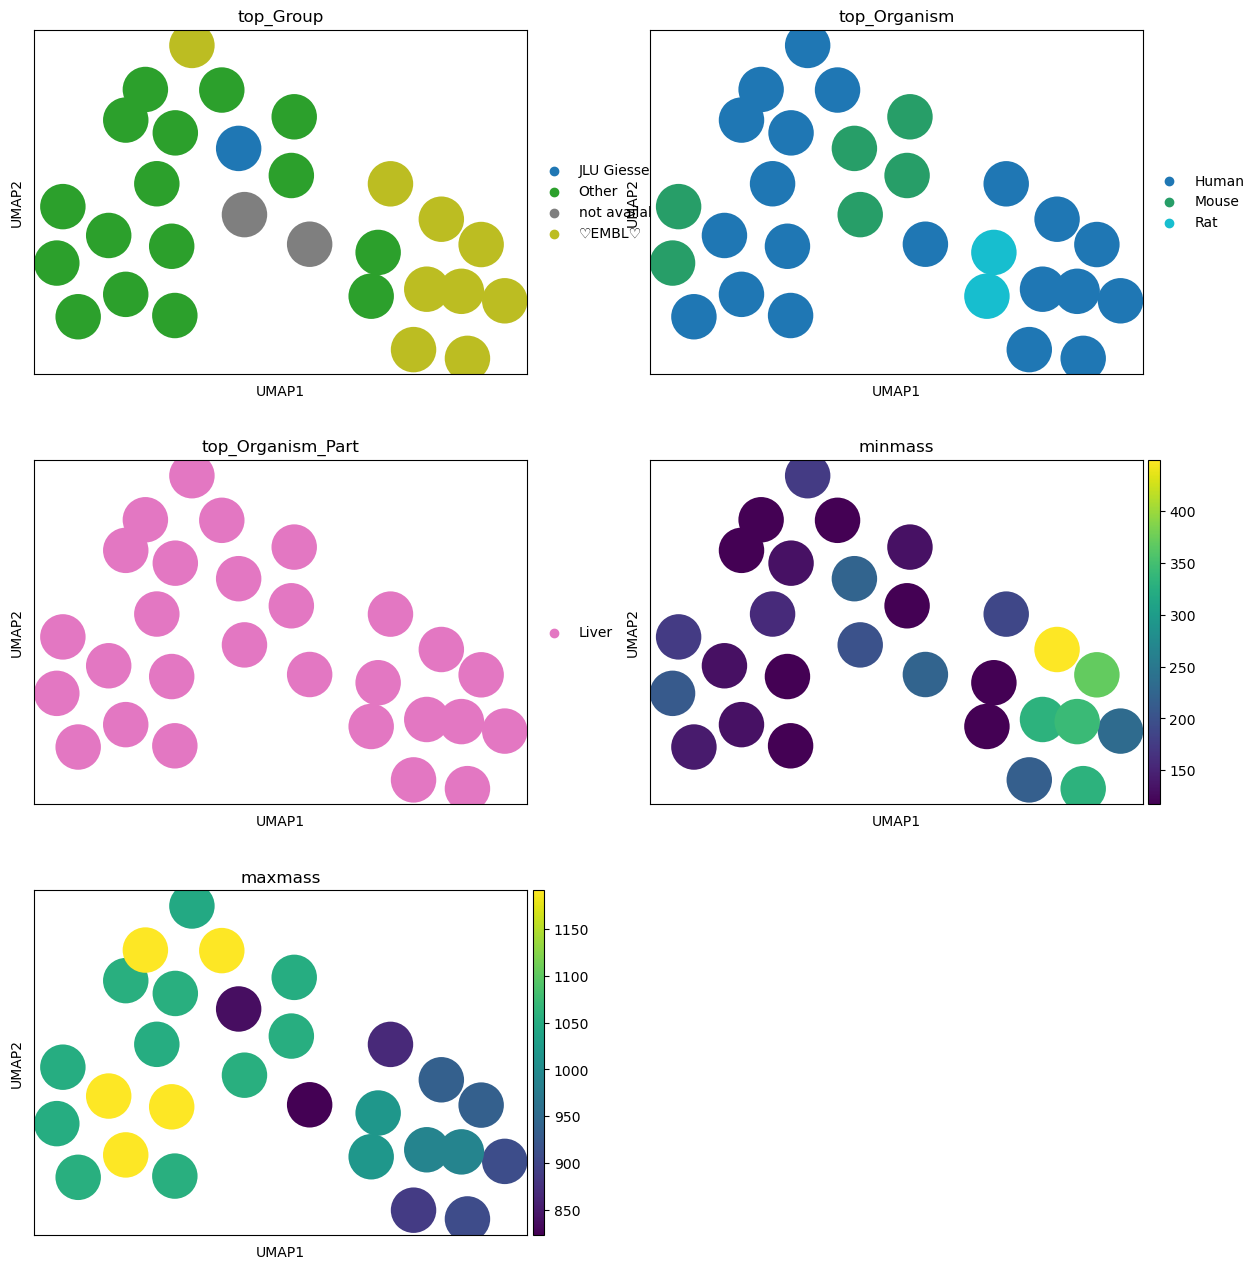

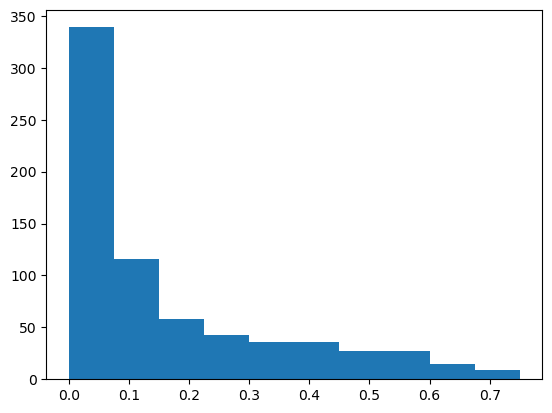

In [292]:
tissue = 'Liver'
adat = adata_pos_dhb_mz_tissue[adata_pos_dhb_mz_tissue.obs['top_Organism_Part']==tissue, :]

sc.pp.pca(adat)
sc.pp.neighbors(adat, metric='cosine')
sc.tl.leiden(adat)
sc.tl.umap(adat)

min_mass_dict = {}
max_mass_dict = {}

for i in range(adat.X.shape[0]):
    ds_id = adat.obs.index[i]
    dataslice = adat.X[i, :] > 0
    
    min_mass_dict[ds_id] = adat.var['mass'][dataslice].min()
    max_mass_dict[ds_id] = adat.var['mass'][dataslice].max()
    
adat.obs['minmass'] = pd.Series(min_mass_dict)
adat.obs['maxmass'] = pd.Series(max_mass_dict)

sc.pl.umap(adat, color=['top_Group', 'top_Organism', 'top_Organism_Part', 'minmass', 'maxmass'], 
           ncols=2)


mol_freq = pd.Series((adat.X > 0).sum(axis=0), index=adat.var.index) / adat.X.shape[0]

plt.hist(mol_freq)

com = mol_freq.sort_values(ascending=False)[int(len(mol_freq)*mol_freq_cutoff)]

top_datasets = pd.Series((adat.X[:, mol_freq >= com] > 0).sum(axis=1), index=adat.obs.index)

co = top_datasets.sort_values(ascending=False)[int(len(top_datasets)*top_ds_cutoff)]

mol_freq2 = pd.Series((adat.X[top_datasets>=co, :] > 0).sum(axis=0), index=adat.var.index) / adat.X[top_datasets>=co, :].shape[0]

tissue_mol_freq[tissue] = mol_freq2
tissue_top_datasets[tissue] = top_datasets

### Lung

/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


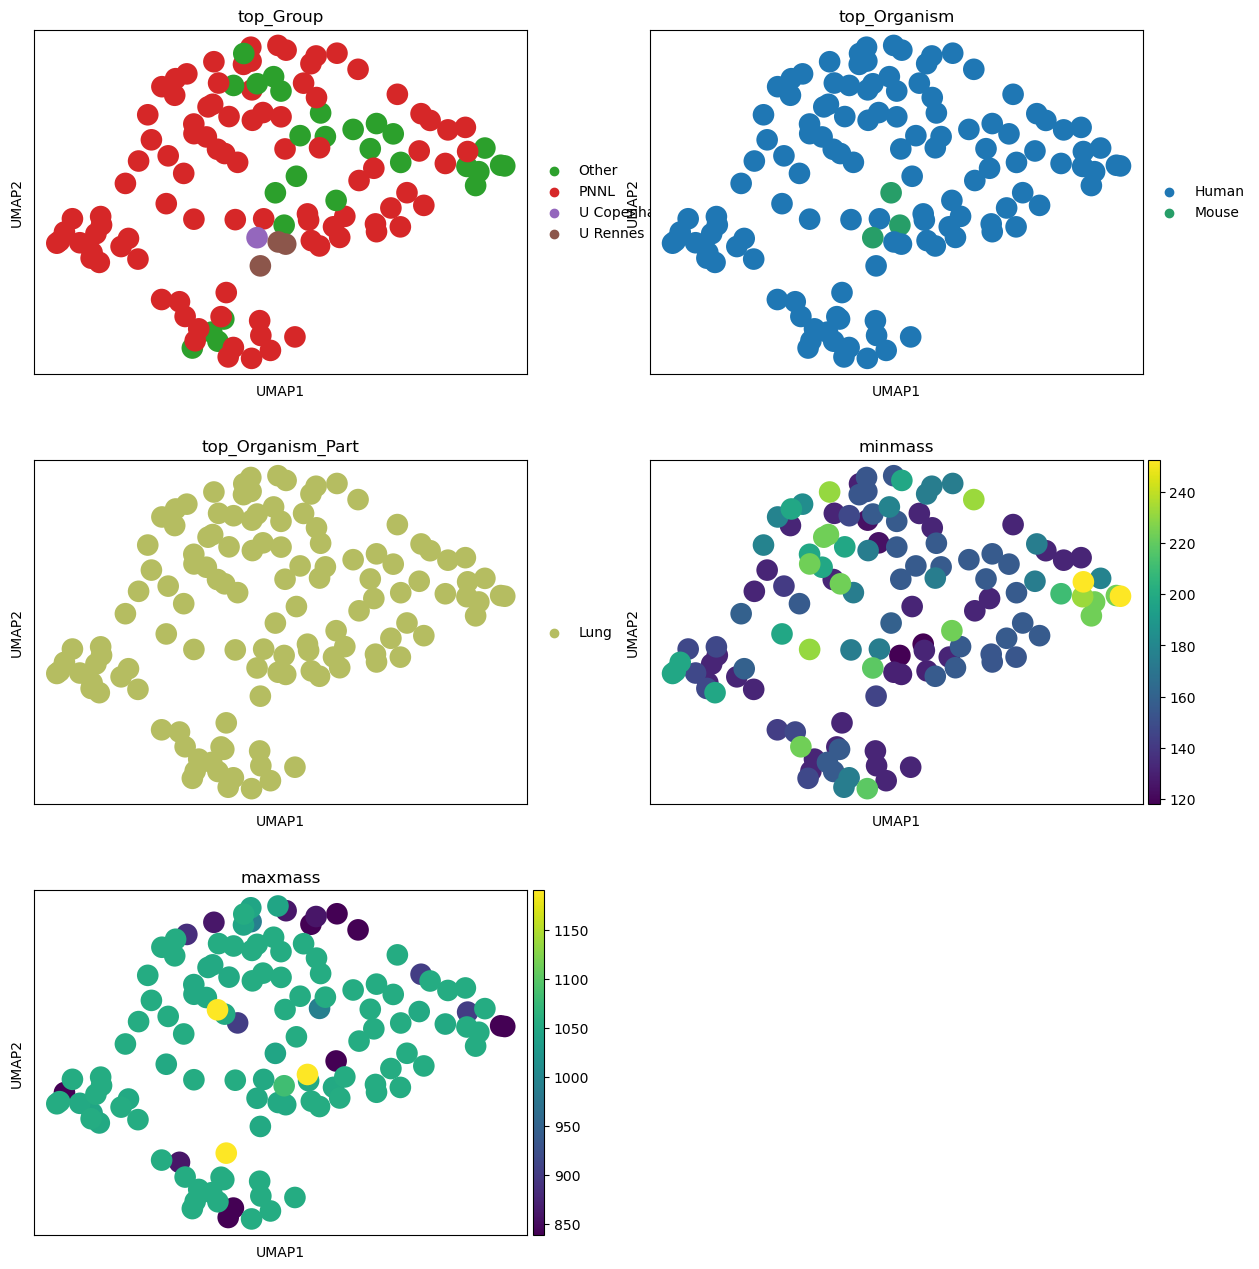

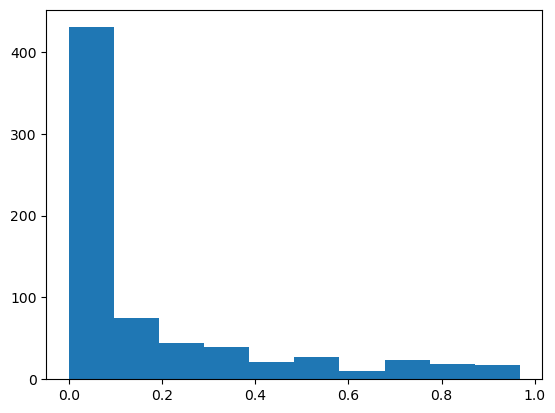

In [293]:
tissue = 'Lung'
adat = adata_pos_dhb_mz_tissue[adata_pos_dhb_mz_tissue.obs['top_Organism_Part']==tissue, :]

sc.pp.pca(adat)
sc.pp.neighbors(adat, metric='cosine')
sc.tl.leiden(adat)
sc.tl.umap(adat)

min_mass_dict = {}
max_mass_dict = {}

for i in range(adat.X.shape[0]):
    ds_id = adat.obs.index[i]
    dataslice = adat.X[i, :] > 0
    
    min_mass_dict[ds_id] = adat.var['mass'][dataslice].min()
    max_mass_dict[ds_id] = adat.var['mass'][dataslice].max()
    
adat.obs['minmass'] = pd.Series(min_mass_dict)
adat.obs['maxmass'] = pd.Series(max_mass_dict)

sc.pl.umap(adat, color=['top_Group', 'top_Organism', 'top_Organism_Part', 'minmass', 'maxmass'], 
           ncols=2)


mol_freq = pd.Series((adat.X > 0).sum(axis=0), index=adat.var.index) / adat.X.shape[0]

plt.hist(mol_freq)

com = mol_freq.sort_values(ascending=False)[int(len(mol_freq)*mol_freq_cutoff)]

top_datasets = pd.Series((adat.X[:, mol_freq >= com] > 0).sum(axis=1), index=adat.obs.index)

co = top_datasets.sort_values(ascending=False)[int(len(top_datasets)*top_ds_cutoff)]

mol_freq2 = pd.Series((adat.X[top_datasets>=co, :] > 0).sum(axis=0), index=adat.var.index) / adat.X[top_datasets>=co, :].shape[0]

tissue_mol_freq[tissue] = mol_freq2
tissue_top_datasets[tissue] = top_datasets

### Ovary

/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


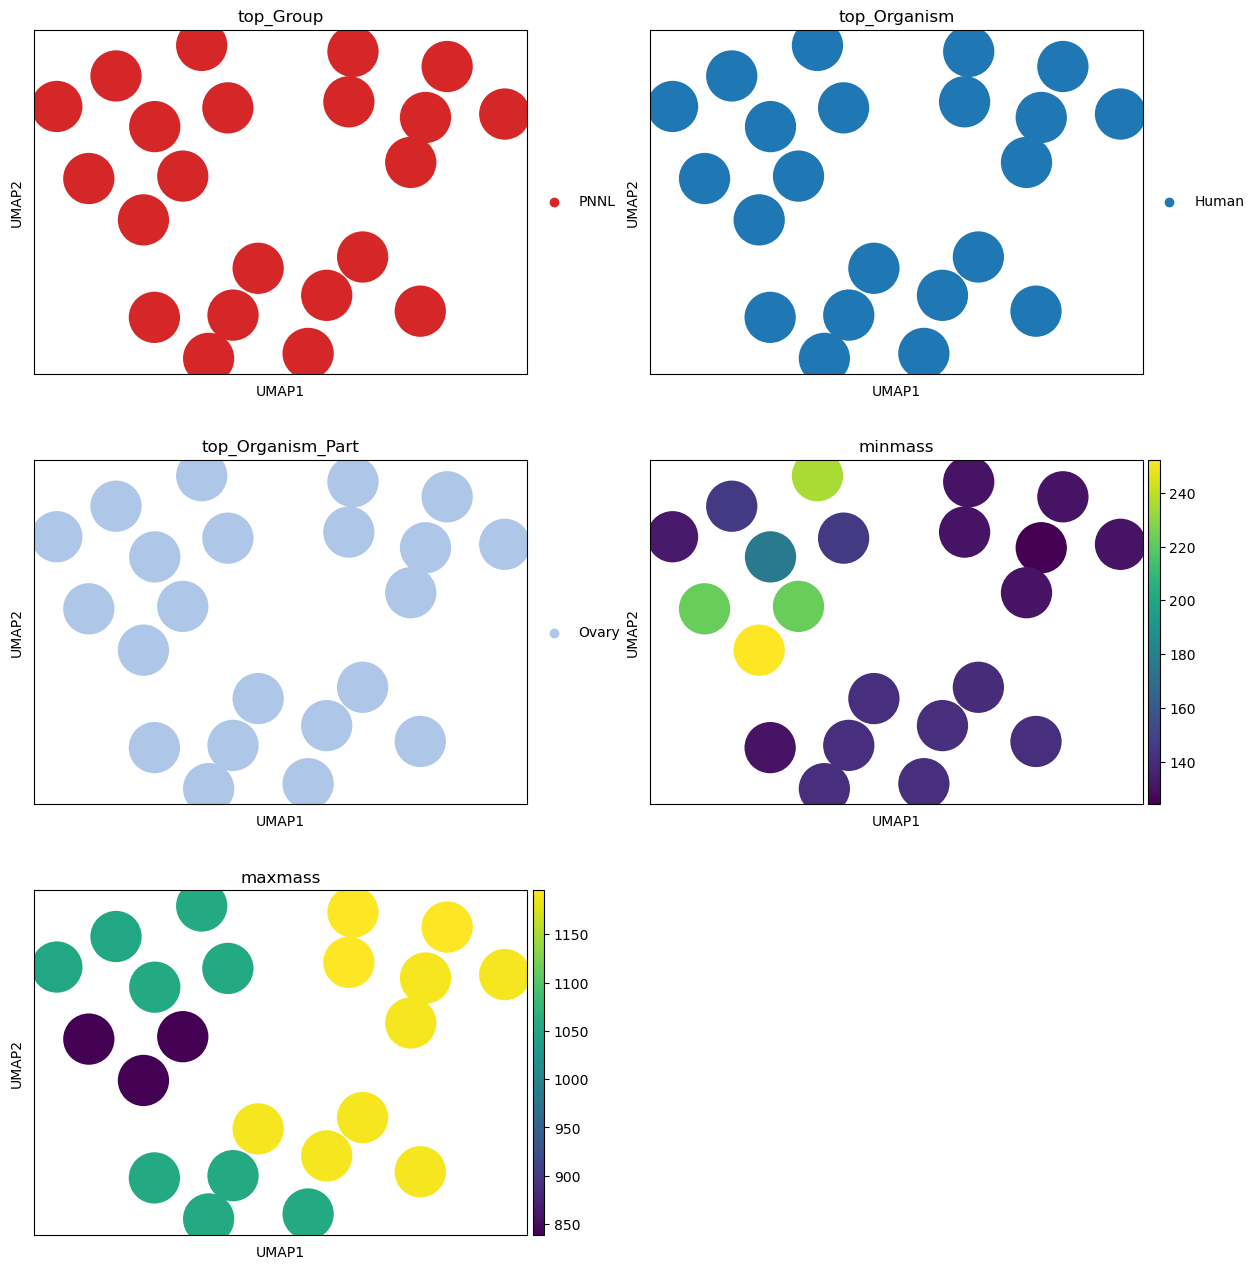

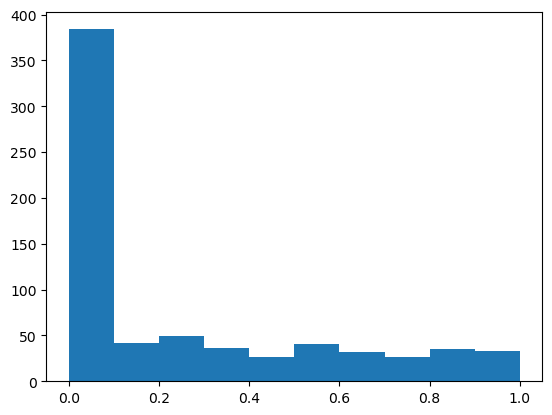

In [294]:
tissue = 'Ovary'
adat = adata_pos_dhb_mz_tissue[adata_pos_dhb_mz_tissue.obs['top_Organism_Part']==tissue, :]

sc.pp.pca(adat)
sc.pp.neighbors(adat, metric='cosine')
sc.tl.leiden(adat)
sc.tl.umap(adat)

min_mass_dict = {}
max_mass_dict = {}

for i in range(adat.X.shape[0]):
    ds_id = adat.obs.index[i]
    dataslice = adat.X[i, :] > 0
    
    min_mass_dict[ds_id] = adat.var['mass'][dataslice].min()
    max_mass_dict[ds_id] = adat.var['mass'][dataslice].max()
    
adat.obs['minmass'] = pd.Series(min_mass_dict)
adat.obs['maxmass'] = pd.Series(max_mass_dict)

sc.pl.umap(adat, color=['top_Group', 'top_Organism', 'top_Organism_Part', 'minmass', 'maxmass'], 
           ncols=2)


mol_freq = pd.Series((adat.X > 0).sum(axis=0), index=adat.var.index) / adat.X.shape[0]

plt.hist(mol_freq)

com = mol_freq.sort_values(ascending=False)[int(len(mol_freq)*mol_freq_cutoff)]

top_datasets = pd.Series((adat.X[:, mol_freq >= com] > 0).sum(axis=1), index=adat.obs.index)

co = top_datasets.sort_values(ascending=False)[int(len(top_datasets)*top_ds_cutoff)]

mol_freq2 = pd.Series((adat.X[top_datasets>=co, :] > 0).sum(axis=0), index=adat.var.index) / adat.X[top_datasets>=co, :].shape[0]

tissue_mol_freq[tissue] = mol_freq2
tissue_top_datasets[tissue] = top_datasets

### Skin

/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


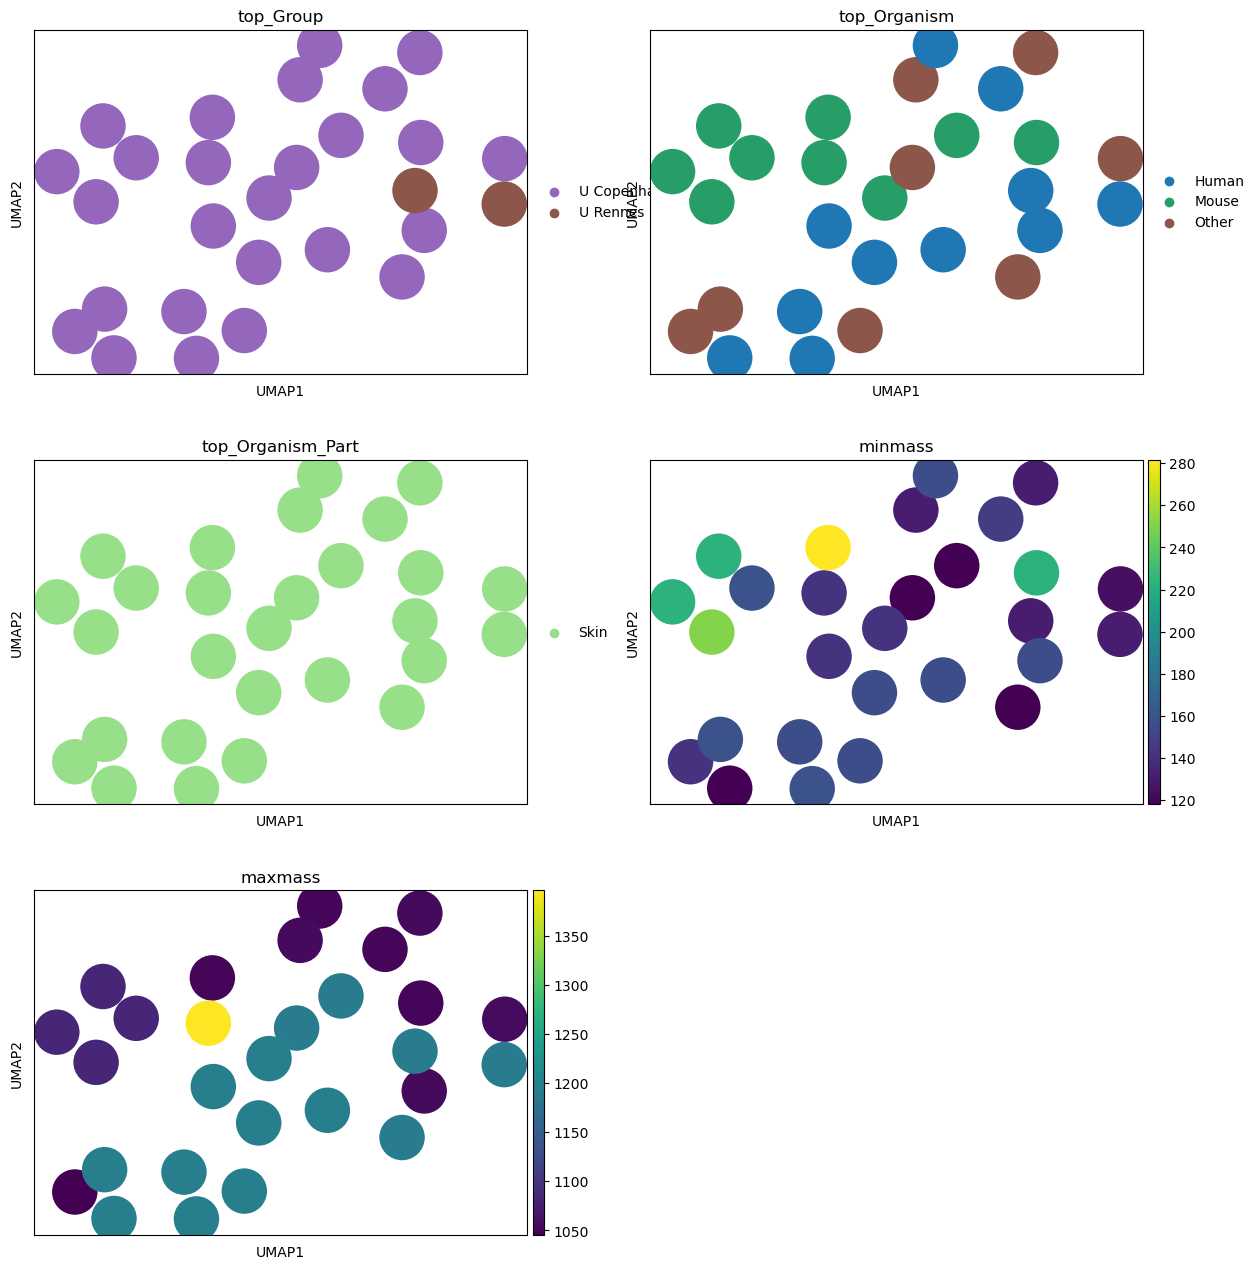

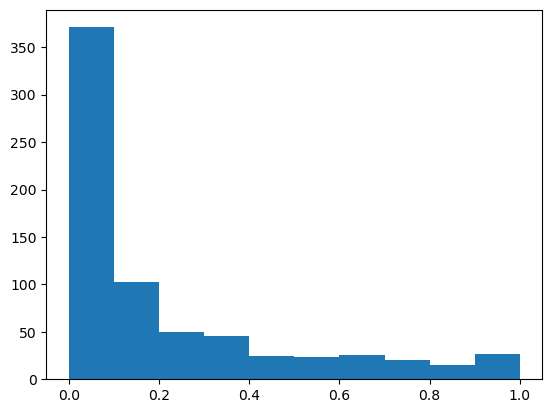

In [295]:
tissue = 'Skin'
adat = adata_pos_dhb_mz_tissue[adata_pos_dhb_mz_tissue.obs['top_Organism_Part']==tissue, :]

sc.pp.pca(adat)
sc.pp.neighbors(adat, metric='cosine')
sc.tl.leiden(adat)
sc.tl.umap(adat)

min_mass_dict = {}
max_mass_dict = {}

for i in range(adat.X.shape[0]):
    ds_id = adat.obs.index[i]
    dataslice = adat.X[i, :] > 0
    
    min_mass_dict[ds_id] = adat.var['mass'][dataslice].min()
    max_mass_dict[ds_id] = adat.var['mass'][dataslice].max()
    
adat.obs['minmass'] = pd.Series(min_mass_dict)
adat.obs['maxmass'] = pd.Series(max_mass_dict)

sc.pl.umap(adat, color=['top_Group', 'top_Organism', 'top_Organism_Part', 'minmass', 'maxmass'], 
           ncols=2)


mol_freq = pd.Series((adat.X > 0).sum(axis=0), index=adat.var.index) / adat.X.shape[0]

plt.hist(mol_freq)

com = mol_freq.sort_values(ascending=False)[int(len(mol_freq)*mol_freq_cutoff)]

top_datasets = pd.Series((adat.X[:, mol_freq >= com] > 0).sum(axis=1), index=adat.obs.index)

co = top_datasets.sort_values(ascending=False)[int(len(top_datasets)*top_ds_cutoff)]

mol_freq2 = pd.Series((adat.X[top_datasets>=co, :] > 0).sum(axis=0), index=adat.var.index) / adat.X[top_datasets>=co, :].shape[0]

tissue_mol_freq[tissue] = mol_freq2
tissue_top_datasets[tissue] = top_datasets

## Tissue similarity

Dataset thresholding

In [296]:
freq_tab = pd.DataFrame(tissue_mol_freq).transpose()
sim_tab = pd.DataFrame(pairwise_kernels(freq_tab, metric='cosine'), index=freq_tab.index, columns=freq_tab.index)

In [297]:
freq_tab

molecule,C9H18O,C48H86NO8P,C23H45NO5,C59H90O4,C40H80O13P2,C20H35NO2,C57H85O4,C14H14O5S,C40H77O8P,C39H72NO8P,...,C59H108O6,C46H84NO8P,C15H22N6O5S,C9H13N2O8P,C35H64O4,C18H37NO2,C10H21NO4,C41H80NO8P,C43H82NO8P,C13H8O4
Brain,0.689655,0.310345,0.137931,0.000000,0.37931,0.034483,0.000000,0.172414,0.034483,0.000000,...,0.000000,1.0,0.655172,0.000000,0.103448,0.034483,0.724138,0.793103,0.206897,0.275862
Colon,0.000000,1.000000,0.000000,0.500000,0.00000,0.000000,0.000000,0.333333,0.000000,0.000000,...,0.833333,1.0,1.000000,0.166667,1.000000,0.000000,0.833333,1.000000,1.000000,0.000000
Epididymis,1.000000,1.000000,0.000000,0.051724,0.00000,0.000000,0.155172,0.000000,0.000000,0.000000,...,0.000000,1.0,0.000000,0.000000,0.982759,0.000000,1.000000,1.000000,0.931034,0.000000
Kidney,0.000000,0.475000,0.400000,0.191667,0.00000,0.033333,0.291667,0.133333,0.141667,0.000000,...,0.183333,1.0,0.283333,0.108333,0.316667,0.133333,0.233333,0.483333,0.775000,0.050000
Liver,0.000000,1.000000,0.000000,0.000000,0.00000,0.000000,0.571429,0.000000,0.000000,0.000000,...,0.714286,1.0,0.285714,0.000000,0.571429,0.000000,0.285714,1.000000,1.000000,0.000000
Lung,0.000000,0.612903,0.000000,0.000000,0.00000,0.000000,0.451613,0.161290,0.000000,0.000000,...,0.129032,1.0,0.000000,0.258065,0.580645,0.064516,0.000000,1.000000,0.903226,0.064516
Ovary,0.000000,1.000000,0.200000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.200000,...,1.000000,1.0,1.000000,0.600000,0.600000,0.000000,1.000000,1.000000,1.000000,0.000000
Skin,0.333333,1.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.166667,...,0.500000,1.0,0.000000,0.000000,0.833333,0.166667,0.000000,1.000000,1.000000,0.000000


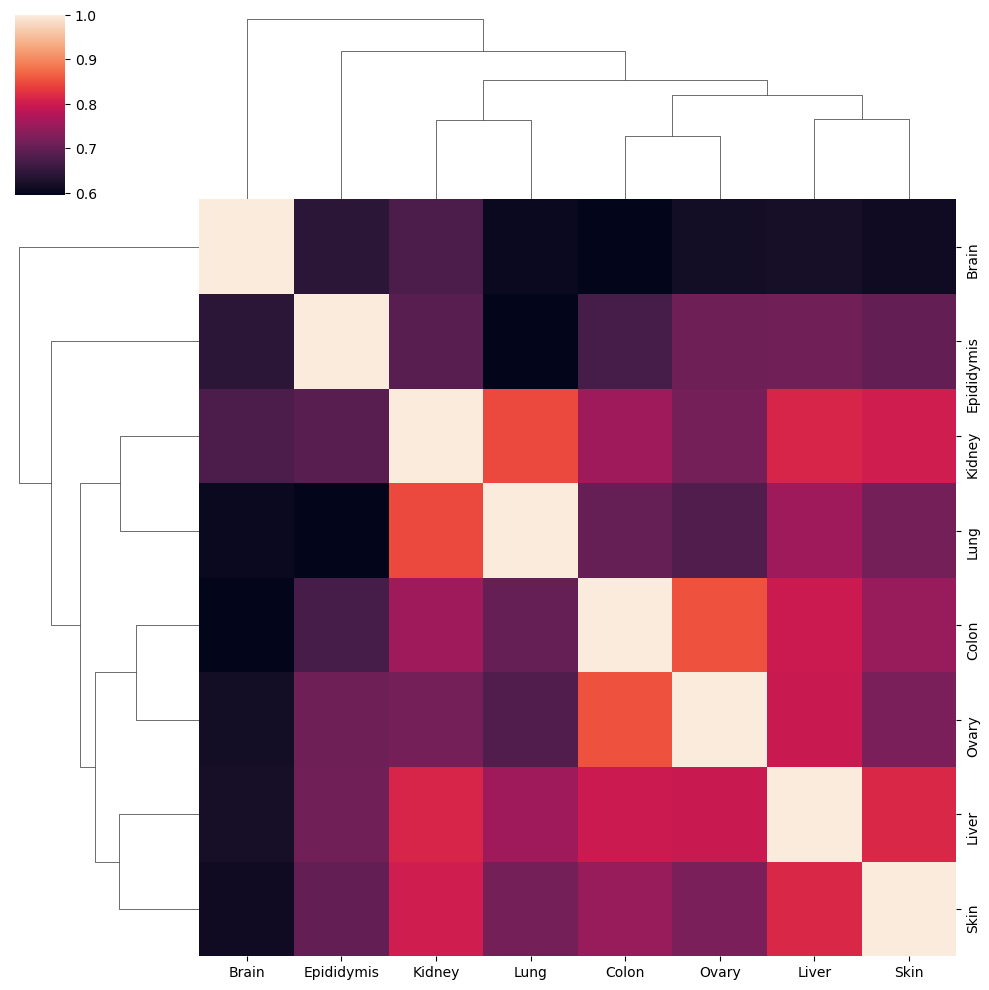

In [298]:
sns.clustermap(sim_tab)

## Next step

Look into the top ions that two tissues share

In [303]:
tissue_top_datasets['Kidney'].sort_values()

2017-11-08_17h05m33s     0
2017-07-12_09h20m54s     0
2017-07-13_06h47m01s     0
2017-07-12_12h55m05s     0
2017-11-10_19h20m00s     1
                        ..
2020-01-09_21h14m40s    70
2020-01-06_22h03m31s    70
2020-03-11_16h38m34s    70
2020-01-09_19h06m59s    71
2020-01-21_22h56m53s    71
Length: 598, dtype: int64

In [49]:
tissue_list

['Brain', 'Colon', 'Epididymis', 'Kidney', 'Liver', 'Lung', 'Ovary', 'Skin']